# Introduction
> Time series forecasting is the process of analyzing time series data using statistics and modeling to make predictions and inform strategic decision-making.

Task -: Time Series Forecasting with Machine Learning to Forecast Energy Consumption

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
from sklearn.metrics import mean_squared_error

# color plates for visualizing
color_pal = sns.color_palette()

# Time series data can be classified into two types:

1. Measurements gathered at regular time intervals (metrics)
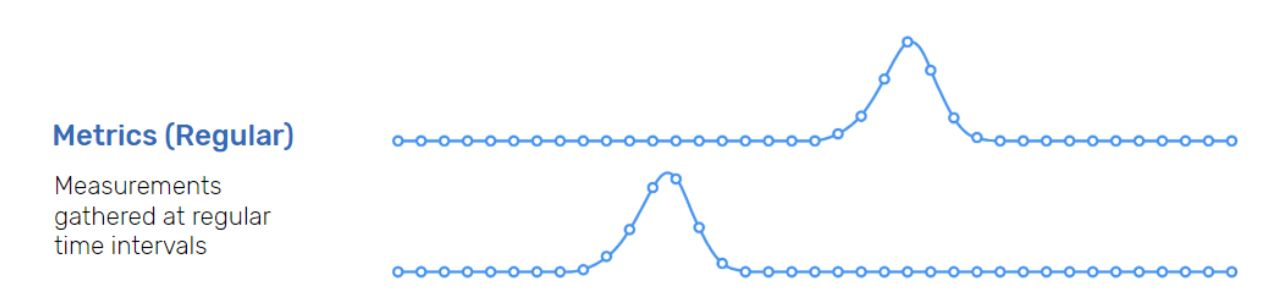
1. Measurements gathered at irregular time intervals (events)
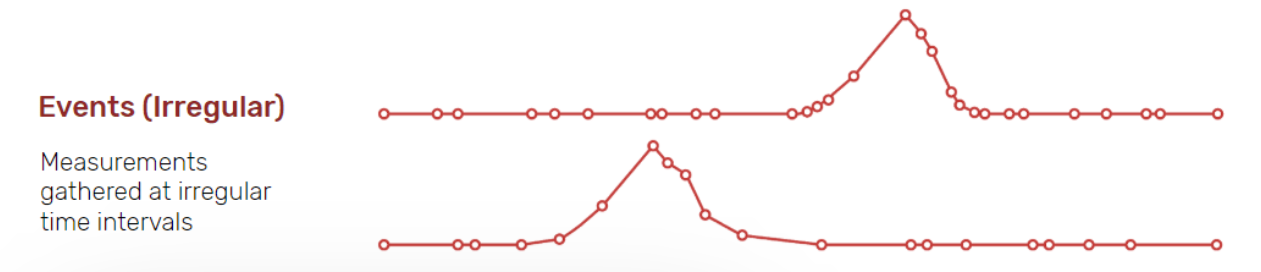

In [2]:
# Reading Data
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [3]:
#setting datetime column as a index
df = df.set_index('Datetime')
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [4]:
#checking for index datatype
df.index

Index(['2005-12-31 01:00:00', '2005-12-31 02:00:00', '2005-12-31 03:00:00',
       '2005-12-31 04:00:00', '2005-12-31 05:00:00', '2005-12-31 06:00:00',
       '2005-12-31 07:00:00', '2005-12-31 08:00:00', '2005-12-31 09:00:00',
       '2005-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=116189)

In [5]:
#change index data type 'object' to 'Datetime'
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2005-12-31 01:00:00', '2005-12-31 02:00:00',
               '2005-12-31 03:00:00', '2005-12-31 04:00:00',
               '2005-12-31 05:00:00', '2005-12-31 06:00:00',
               '2005-12-31 07:00:00', '2005-12-31 08:00:00',
               '2005-12-31 09:00:00', '2005-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=116189, freq=None)

In [6]:
#checking the color plate
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

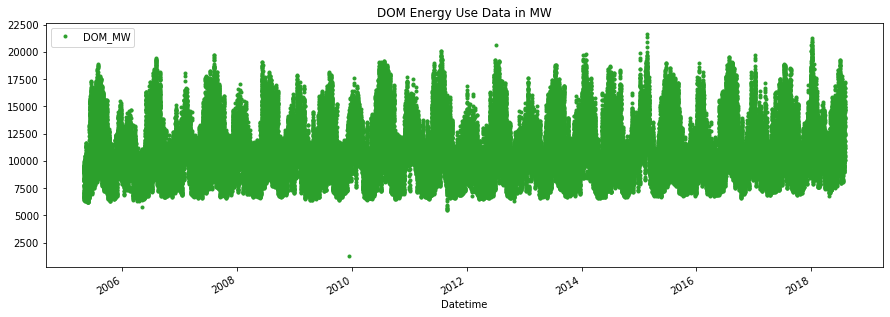

In [7]:
#visualizing the data 
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[2],
        title='DOM Energy Use Data in MW')
plt.show()

# Split Data into Training & Testing

In [8]:
train_df = df.loc[df.index < '01-01-2015']
test_df = df.loc[df.index >= '01-01-2015']

In [9]:
train_df.shape, test_df.shape

((84749, 1), (31440, 1))

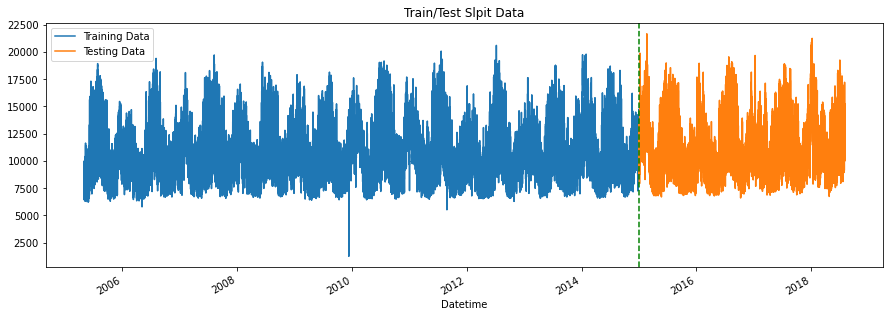

In [10]:
#visualizig the training and testing data
fig,ax = plt.subplots(figsize=(15,5))
train_df.plot(ax=ax,label='Training Data',title='Train/Test Slpit Data')
test_df.plot(ax=ax,label='Testing Data')
ax.legend(['Training Data','Testing Data'])
ax.axvline('01-01-2015',color='green',ls='--')
plt.show()

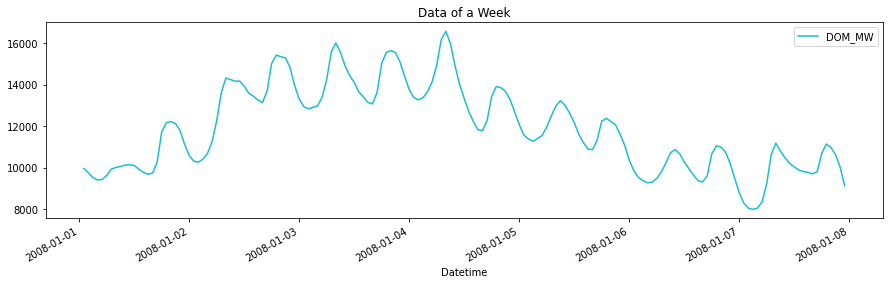

In [11]:
#Visualizing the data for a week
df_week = df.loc[(df.index > '01-01-2008') &(df.index < '01-08-2008')]
df_week.plot(figsize=(15,4),color=color_pal[9],title='Data of a Week')
plt.show()

# Feature Creation
> ### **Create time series features based on time series index.**

In [12]:
# function for creating features 
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day-of-week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter 
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day-of-year'] = df.index.dayofyear
    return df

In [13]:
df = create_features(df)
df.head()

,DOM_MW,hour,day-of-week,quarter,month,year,day-of-year
Datetime,,,,,,,
2005-12-31 01:00:00,9389.0,1,5,4,12,2005,365
2005-12-31 02:00:00,9070.0,2,5,4,12,2005,365
2005-12-31 03:00:00,9001.0,3,5,4,12,2005,365
2005-12-31 04:00:00,9042.0,4,5,4,12,2005,365
2005-12-31 05:00:00,9132.0,5,5,4,12,2005,365


# Visualizing our features & Target Relationship

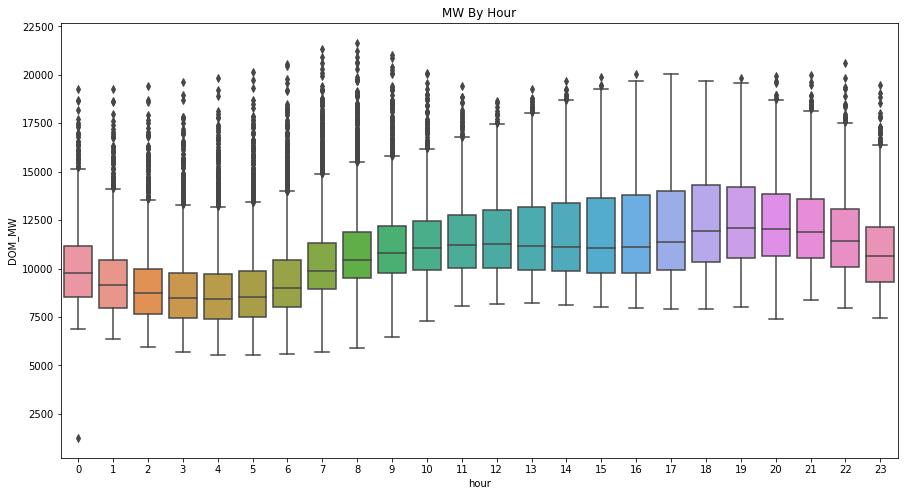

In [14]:
#for relationship ploting here we seaborn boxplot
## Plot for per Hours Energy use
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df,x='hour',y='DOM_MW')
ax.set_title("MW By Hour") 
plt.show()

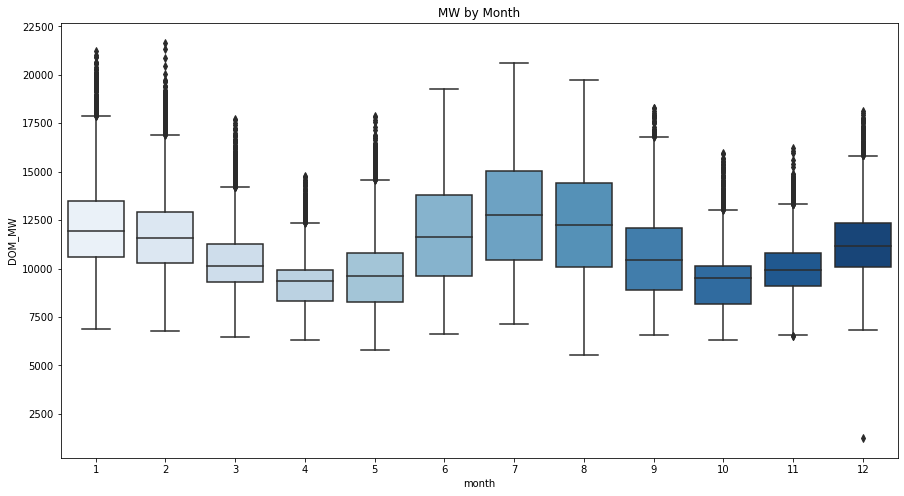

In [15]:
# Plot for per month Energy use
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='DOM_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

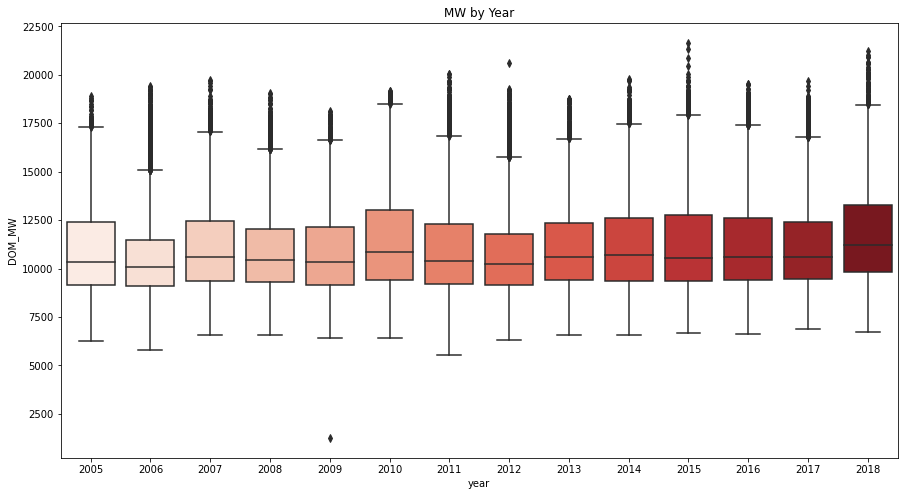

In [16]:
# Plot for per year Energy use
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='year', y='DOM_MW', palette='Reds')
ax.set_title('MW by Year')
plt.show()

# Create Our ML Model (XGBRegressor-Model)
> XGBoost is a powerful approach for building supervised regression models. The validity of this statement can be inferred by knowing about its (XGBoost) objective function and base learners. The objective function contains loss function and a regularization term. It tells about the difference between actual values and predicted values, i.e how far the model results are from the real values.

In [17]:
#adding features in training and testing data
train = create_features(train_df)
test = create_features(test_df)

In [18]:
df.columns

Index(['DOM_MW', 'hour', 'day-of-week', 'quarter', 'month', 'year',
       'day-of-year'],
      dtype='object')

In [19]:
#assigning our features and targets
Features  = ['hour', 'day-of-week', 'quarter', 'month', 'year','day-of-year']
Target = 'DOM_MW'

In [20]:
X_train = train[Features] 
y_train = train[Target]

X_test = test[Features] 
y_test = test[Target]

In [21]:
#getting the shape of all data test and train data
X_train.shape, y_train.shape,X_test.shape,y_test.shape,

((84749, 6), (84749,), (31440, 6), (31440,))

In [22]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [23]:
#fitting our model
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[07:57:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10997.63440	validation_1-rmse:11383.52018
[100]	validation_0-rmse:4303.26829	validation_1-rmse:4701.22873
[200]	validation_0-rmse:2098.43932	validation_1-rmse:2494.39697
[300]	validation_0-rmse:1514.98174	validation_1-rmse:1882.05395
[400]	validation_0-rmse:1377.75996	validation_1-rmse:1719.47449
[500]	validation_0-rmse:1330.58344	validation_1-rmse:1671.30865
[600]	validation_0-rmse:1305.11931	validation_1-rmse:1652.31879
[700]	validation_0-rmse:1284.12400	validation_1-rmse:1644.83704
[800]	validation_0-rmse:1266.99906	validation_1-rmse:1638.85043
[900]	validation_0-rmse:1251.46453	validation_1-rmse:1634.52674
[999]	validation_0-rmse:1237.65332	validation_1-rmse:1629.59180


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

# Features Importance

<AxesSubplot:title={'center':'feature importance'}>

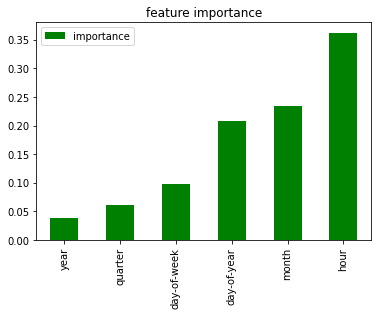

In [24]:
pd.DataFrame(model.feature_importances_,
            index = model.feature_names_in_,
            columns=['importance']).sort_values('importance').plot(kind='bar',title='feature importance',color='green')

# Forcast On Test Data 

In [25]:
#get predictions and store it in test df
test['predictions'] = model.predict(X_test)

In [26]:
#merge test prediction df in main df
df_1 = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)

In [27]:
df_1

,DOM_MW,hour,day-of-week,quarter,month,year,day-of-year,predictions
Datetime,,,,,,,,
2005-05-01 01:00:00,7190.0,1,6,2,5,2005,121,NaN
2005-05-01 02:00:00,6803.0,2,6,2,5,2005,121,NaN
2005-05-01 03:00:00,6583.0,3,6,2,5,2005,121,NaN
2005-05-01 04:00:00,6452.0,4,6,2,5,2005,121,NaN
2005-05-01 05:00:00,6445.0,5,6,2,5,2005,121,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,14038.0,20,3,3,8,2018,214,14832.725586
2018-08-02 21:00:00,13832.0,21,3,3,8,2018,214,14736.689453
2018-08-02 22:00:00,13312.0,22,3,3,8,2018,214,14046.119141


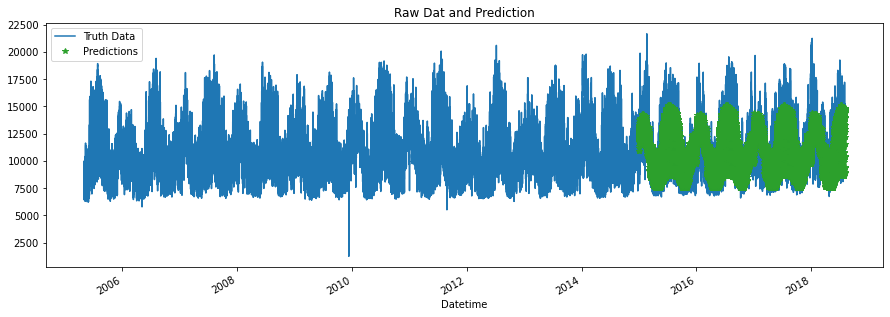

In [28]:
#visualize predictions on test data
ax = df_1[['DOM_MW']].plot(figsize=(15, 5))
df_1['predictions'].plot(ax=ax, style='*',color = color_pal[2])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

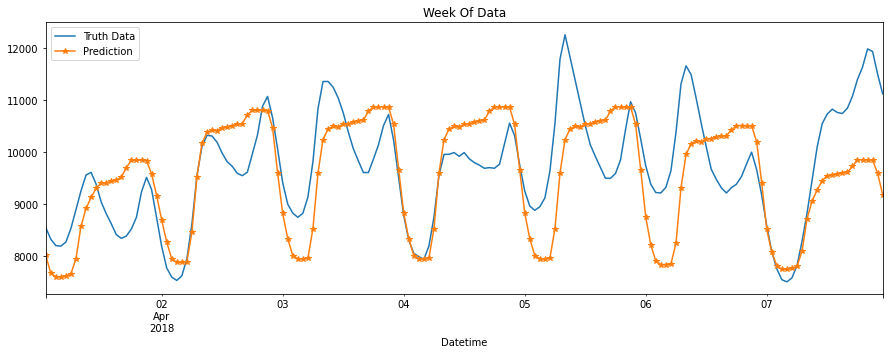

In [29]:
#predictions on a week of power consumption data
ax = df_1.loc[(df_1.index > '04-01-2018') & (df_1.index < '04-08-2018')]['DOM_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_1.loc[(df_1.index > '04-01-2018') & (df_1.index < '04-08-2018')]['predictions'] \
    .plot(style='-*')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Getting Score

In [30]:
score = np.sqrt(mean_squared_error(test['DOM_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1629.59


# Error Calculation

In [31]:
test['error'] = np.abs(test[Target] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    6901.411865
2018-01-07    6789.172770
2018-01-06    6719.683512
2018-01-01    5816.638468
2018-01-05    5750.050171
2015-02-21    5749.673340
2015-02-16    5520.277669
2015-02-19    5379.609985
2017-12-31    5265.098551
2015-02-15    5001.299601
Name: error, dtype: float64

# Prediction on Complete Data

In [32]:
#copy all features in df_2 for predictions
df[Features]

,hour,day-of-week,quarter,month,year,day-of-year
Datetime,,,,,,
2005-12-31 01:00:00,1,5,4,12,2005,365
2005-12-31 02:00:00,2,5,4,12,2005,365
2005-12-31 03:00:00,3,5,4,12,2005,365
2005-12-31 04:00:00,4,5,4,12,2005,365
2005-12-31 05:00:00,5,5,4,12,2005,365
...,...,...,...,...,...,...
2018-01-01 20:00:00,20,0,1,1,2018,1
2018-01-01 21:00:00,21,0,1,1,2018,1
2018-01-01 22:00:00,22,0,1,1,2018,1


In [33]:
#get predictions and store it in main-df
df['predictions'] = model.predict(df[Features])

In [34]:
df

,DOM_MW,hour,day-of-week,quarter,month,year,day-of-year,predictions
Datetime,,,,,,,,
2005-12-31 01:00:00,9389.0,1,5,4,12,2005,365,9642.182617
2005-12-31 02:00:00,9070.0,2,5,4,12,2005,365,9361.961914
2005-12-31 03:00:00,9001.0,3,5,4,12,2005,365,9293.806641
2005-12-31 04:00:00,9042.0,4,5,4,12,2005,365,9293.806641
2005-12-31 05:00:00,9132.0,5,5,4,12,2005,365,9327.960938
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,18418.0,20,0,1,1,2018,1,12139.840820
2018-01-01 21:00:00,18567.0,21,0,1,1,2018,1,12155.712891
2018-01-01 22:00:00,18307.0,22,0,1,1,2018,1,11941.222656


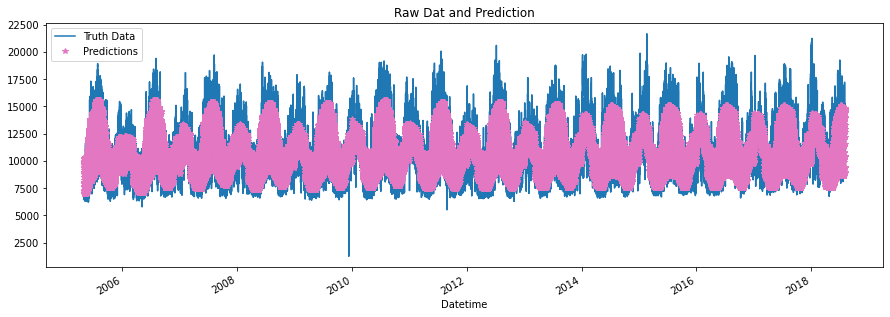

In [35]:
#visualize predictions on test data
ax = df[['DOM_MW']].plot(figsize=(15, 5))
df['predictions'].plot(ax=ax, style='*',color = color_pal[6])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [36]:
score = np.sqrt(mean_squared_error(df['DOM_MW'], df['predictions']))
print(f'RMSE Score on Complete data: {score:0.2f}')

RMSE Score on Complete data: 1355.04


# END